This notebook classifies whether a movie review as positive or negative. This is a binary (two-class) classification. This notebook follows a TensorFlow tutorial:
https://www.tensorflow.org/hub/tutorials/tf2_text_classification

The IMDB dataset contains 50,000 movie reviews. With half of the data split for training and the other half for testing.

This notebook uses tf.keras, a high-level API to build and train models in TensorFLow.


### Setup

In [4]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.3.0
Eager mode:  True
Hub version:  0.9.0
GPU is NOT AVAILABLE


### Download the IMDB dataset
Download dataset to my machine.

In [5]:
train_data, test_data = tfds.load("imdb_reviews", split=["train", "test"],
                                 batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

Shuffling and writing examples to C:\Users\vinhe\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteAZVKWM\imdb_reviews-train.tfrecord


Shuffling and writing examples to C:\Users\vinhe\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteAZVKWM\imdb_reviews-test.tfrecord


Shuffling and writing examples to C:\Users\vinhe\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incompleteAZVKWM\imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to C:\Users\vinhe\tensorflow_datasets\imdb_reviews\plain_text\1.0.0. Subsequent calls will reuse this data.


### Explore data
- Label is an integer value of 0 or 1, where 0 is a negative review, and 1 is a positive review.
- The sentence represents the movie review.

In [6]:
print("Training entries: {}, test entries: {}".format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [8]:
# print first 5 entries
train_examples[:5]

array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot 

In [9]:
# print first 5 labels
train_labels[:5]

array([0, 0, 0, 1, 1], dtype=int64)

### Build the model

The neural network is created by stacking layers, this requires three main architectural decisions:
- How to represent the text?
- How many laters to use in the model?
- How many hidden units to use for each layer?

This example has the input data consisting of sentence. The labels to predict are 0 or 1.

One method to represent the text is to convert sentences into embedding vectors. Let's use a pre-trained text embedding vector as the first layer, this has two advantages:
- this takes care of text preprocessing,
- we can benefit from transfer learning.

This example will use a model from TensorFlow Hub called google/tf2-preview/gnews-swivel-20dim/1.

There are three other models to test for this tutorial:
- google/tf2-preview/gnews-swivel-20dim-with-oov/1 - same as google/tf2-preview/gnews-swivel-20dim/1, but with 2.5% vocabulary converted to OOV buckets. This can help if vocabulary of the task and vocabulary of the model don't fully overlap.
- google/tf2-preview/nnlm-en-dim50/1 - A much larger model with ~1M vocabulary size and 50 dimensions.
- google/tf2-preview/nnlm-en-dim128/1 - Even larger model with ~1M vocabulary size and 128 dimensions.

Create a Keras layer that uses a TensorFlow Hub model to embed the sentences, then apply it on a few input examples.

Note that the output shape of the produced embeddings is a expected (num_examples, embedding_dimension).

In [12]:
model = 'https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1'
hub_layer = hub.KerasLayer(model, output_shape=[20], input_shape=[],
                          dtype=tf.string, trainable=True)
hub_layer(train_examples[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 1.765786  , -3.882232  ,  3.9134233 , -1.5557289 , -3.3362343 ,
        -1.7357955 , -1.9954445 ,  1.2989551 ,  5.081598  , -1.1041286 ,
        -2.0503852 , -0.72675157, -0.65675956,  0.24436149, -3.7208383 ,
         2.0954835 ,  2.2969332 , -2.0689783 , -2.9489717 , -1.1315987 ],
       [ 1.8804485 , -2.5852382 ,  3.4066997 ,  1.0982676 , -4.056685  ,
        -4.891284  , -2.785554  ,  1.3874227 ,  3.8476458 , -0.9256538 ,
        -1.896706  ,  1.2113281 ,  0.11474707,  0.76209456, -4.8791065 ,
         2.906149  ,  4.7087674 , -2.3652055 , -3.5015898 , -1.6390051 ],
       [ 0.71152234, -0.6353217 ,  1.7385626 , -1.1168286 , -0.5451594 ,
        -1.1808156 ,  0.09504455,  1.4653089 ,  0.66059524,  0.79308075,
        -2.2268345 ,  0.07446612, -1.4075904 , -0.70645386, -1.907037  ,
         1.4419787 ,  1.9551861 , -0.42660055, -2.8022065 ,  0.43727064]],
      dtype=float32)>

Now build the full model:

In [13]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 16)                336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 400,373
Trainable params: 400,373
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:
1. The first layer is a TensorFlow Hub layer. This layer used a pre-trained Saved Model to map a sentence into its embedding vector. The model (https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1) splits the sentence into tokens, embeds each token, and the combines the embedding.
2. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
3. The final layer is densely connected with a single output node. This output logits: the log-odds of the true class, according to the model.

#### Hidden units
The above models has two intermediate/hidden layers, between the input and output. The number of outputs (units, nodes, or neurons) is the dimension of the representational space for the layer, i.e. the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, this makes the network more computationally expensive and may lead to learning unwanted patterns, which improve performance on training data but not on test data, i.e. overfitting.

#### Loss function and optimiser
A model needs a loss function and an optimiser for training. As this is a binary classification problem and model outputs a probability (a single-unit layer with a sigmoid activation), a binary_crossentropy loss function is chosen.

There are other loss functions that can be selected, for example mean squared error. Typically, binary_crossentropy is better for dealing with probabilities, as it measures the "distance" between probability distributions, in this example, between the ground-truth distribution and the predictions.

Now configure the model to use an optimiser and loss function:

In [16]:
model.compile(optimizer='adam',
             loss=tf.losses.BinaryCrossentropy(from_logits=True),
             metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

## Create a validation set
When training, we want to check the accuracy of the model on data it has not seen before. Create a validation set by setting apart 10,000 examples from the original training data. This allows us to develop and tune the model using only training data, tand only use the test data to evaluate the accuracy.

In [20]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

### Train the model
Train the model for 40 epoches in mini-batches of 512 samples, i.e. 40 iterations voer all samples in the x_train and y_train tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [21]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/40
30/30 [==============================] - 3s 105ms/step - loss: 1.0498 - accuracy: 0.4918 - val_loss: 0.7437 - val_accuracy: 0.5455
Epoch 2/40
30/30 [==============================] - 3s 93ms/step - loss: 0.6740 - accuracy: 0.5987 - val_loss: 0.6336 - val_accuracy: 0.6443
Epoch 3/40
30/30 [==============================] - 3s 97ms/step - loss: 0.6098 - accuracy: 0.6825 - val_loss: 0.5974 - val_accuracy: 0.6918
Epoch 4/40
30/30 [==============================] - 2s 63ms/step - loss: 0.5747 - accuracy: 0.7180 - val_loss: 0.5707 - val_accuracy: 0.7143
Epoch 5/40
30/30 [==============================] - 2s 60ms/step - loss: 0.5446 - accuracy: 0.7419 - val_loss: 0.5455 - val_accuracy: 0.7356
Epoch 6/40
30/30 [==============================] - 3s 95ms/step - loss: 0.5144 - accuracy: 0.7632 - val_loss: 0.5200 - val_accuracy: 0.7551
Epoch 7/40
30/30 [==============================] - 3s 95ms/step - loss: 0.4833 - accuracy: 0.7865 - val_loss: 0.4937 - val_accuracy: 0.7758
Epoch 8/40
3

## Evaluate the model
See how the model performs. Two values will be returned. Loss (this number represents the model's error, thus lower is better), and accuracy.

In [22]:
results = model.evaluate(test_data, test_labels)

print(results)

  1/782 [..............................] - ETA: 0s - loss: 0.6316 - accuracy: 0.7812WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0000s vs `on_test_batch_end` time: 0.0078s). Check your callbacks.


782/782 [==============================] - 4s 5ms/step - loss: 0.3829 - accuracy: 0.8604
[0.38285672664642334, 0.8604000210762024]


This relatively naive approach achieves an accuracy of 86%. This model can be improved with more advanced approaches to reach 95%.

## Create a graph of accuracy and loss over time
model.fit() returns a History object that contains a dictionary with everything that occurred during training:

In [23]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

There are four entries: one for each monitored metric during training and validation. These can be used to plot the training and validation loss for comparison, as well as the training and validation accuracy:

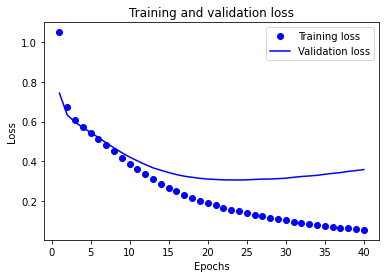

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for " blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# "b" is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

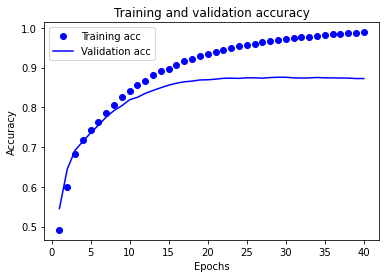

In [25]:
plt.clf() # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

For this plot, the dots represent the training loss and training accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is to be expected when using a gradient descent optimisation, as it should minimise the desired quantity on each iteration.

This is not the case for validation loss and accuracy, as they appear to peak after twenty epochs. This is an example of overfitting, where the model performs better on training data than on new data. After this point, the model over-optimises and learns representations specific to the training data that do not translate to the test data.

In this example, overfitting can be prevented by stopping the training after twenty epochs. This can be achieved using a callback.